# Lab 1: Data Visualization, Data Preprocessing, and Statistical Analysis

**Name:** Aashish Shrestha

**Course Title:** Advanced Big Data and Data Mining (MSCS-634 M20)

**Date:** February 01, 2026

## Dataset
**Transfermarkt (Kaggle) — Football Transfers**

This notebook uses a curated slice of the Transfermarkt Kaggle dataset (transfers).
- Raw file (copied from Kaggle export): `data/transfermarkt_transfers_raw.csv`
- Working file (derived for preprocessing demo): `data/transfermarkt_transfers_working.csv`

The working file contains intentional issues (missing values, duplicates, outliers) so the lab cleaning steps have something to fix.

In [89]:
import os
import io
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', 50)

In [90]:
# Create an output folder for screenshots/artifacts
SCREENSHOTS_DIR = Path('screenshots')
SCREENSHOTS_DIR.mkdir(parents=True, exist_ok=True)

def save_df_png(df: pd.DataFrame, filename: str, max_rows: int = 12, max_cols: int = 12, font_size: int = 8):
    """Render a small DataFrame as a PNG image (for screenshot-style submission artifacts)."""
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)

    df_view = df.copy()
    if df_view.shape[0] > max_rows:
        df_view = df_view.head(max_rows)
    if df_view.shape[1] > max_cols:
        df_view = df_view.iloc[:, :max_cols]

    fig_w = max(10, df_view.shape[1] * 1.1)
    fig_h = max(2.5, df_view.shape[0] * 0.6)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.axis('off')
    tbl = ax.table(
        cellText=df_view.values,
        colLabels=list(df_view.columns),
        rowLabels=list(df_view.index),
        loc='center',
        cellLoc='center',
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(font_size)
    tbl.scale(1, 1.2)
    fig.tight_layout()
    fig.savefig(SCREENSHOTS_DIR / filename, dpi=200, bbox_inches='tight')
    plt.close(fig)


def save_text_png(text: str, filename: str, font_size: int = 9):
    """Save monospaced text to a PNG (useful for .info()-style outputs)."""
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('off')
    ax.text(0, 1, text, va='top', ha='left', family='monospace', fontsize=font_size)
    fig.tight_layout()
    fig.savefig(SCREENSHOTS_DIR / filename, dpi=200, bbox_inches='tight')
    plt.close(fig)


print(f"Artifacts will be saved under: {SCREENSHOTS_DIR.resolve()}")

Artifacts will be saved under: /Users/L040929/Documents/University of Cumberlands/MSCS-634-M20/lab1/screenshots


## Step 1: Data Collection
- Dataset source: Transfermarkt dataset from Kaggle (football transfers).
- In this lab, I load the prepared working CSV into a Pandas DataFrame and parse `transfer_date` as a datetime column.
- I also export required “screenshot” artifacts to the `screenshots/` folder automatically while the notebook runs.

In [91]:
# Load dataset (working copy for preprocessing tasks)
df = pd.read_csv('data/transfermarkt_transfers_working.csv', parse_dates=['transfer_date'])

# Required: display first five rows
df_head = df.head(5)
save_df_png(df_head, 'tm_01_head.png')
df_head

,player_id,transfer_date,transfer_season,from_club_id,to_club_id,from_club_name,to_club_name,transfer_fee,market_value_in_eur,player_name,transfer_fee_eur,market_value_eur,transfer_year,fee_missing,value_missing,fee_bucket
0,104543,2011-07-19,11/12,12764,1096,Olymp. Lyon B,Royal Antwerp,0.0,NaN,Théo Defourny,0.0,NaN,2011,False,True,<=1m
1,182906,2012-07-01,12/13,6326,8512,Paris SG U19,Paris SG B,NaN,NaN,Mike Maignan,NaN,NaN,2012,True,True,NaN
2,290384,2016-07-22,16/17,10330,703,Benfica B,Nottm Forest,0.0,400000.0,Berto,0.0,400000.0,2016,False,False,<=1m
3,633228,2019-08-13,19/20,39336,22552,Brighton U23,Whitehawk,0.0,NaN,Kacper Lopata,0.0,NaN,2019,False,True,<=1m
4,129554,2012-06-30,11/12,1426,317,VVV-Venlo,Twente FC,0.0,600000.0,Steven Berghuis,0.0,NaN,2012,False,True,<=1m


In [92]:
# Quick overview
df.shape, df.columns.tolist()

((79846, 16),
 ['player_id',
  'transfer_date',
  'transfer_season',
  'from_club_id',
  'to_club_id',
  'from_club_name',
  'to_club_name',
  'transfer_fee',
  'market_value_in_eur',
  'player_name',
  'transfer_fee_eur',
  'market_value_eur',
  'transfer_year',
  'fee_missing',
  'value_missing',
  'fee_bucket'])

In [93]:
# Missingness summary (transfer fees are often missing in real transfer datasets)
df[['transfer_fee_eur', 'market_value_eur']].isna().sum()

transfer_fee_eur    27780
market_value_eur    30886
dtype: int64

## Step 2: Data Visualization (2+ required)
Take screenshots of at least two charts and write 2–4 sentences of insight under each.

For this dataset, fees/values are heavily right-skewed, so plotting on a log scale is often clearer.

### Visualization goals
- Use log transforms because transfer fees/values are very right-skewed.
- Save figures to `screenshots/` so the evidence is reproducible (no manual screenshots needed).

### 2.1 Histogram (Distribution)
This histogram shows the distribution of transfer fees after applying a log10 transform to handle skew.

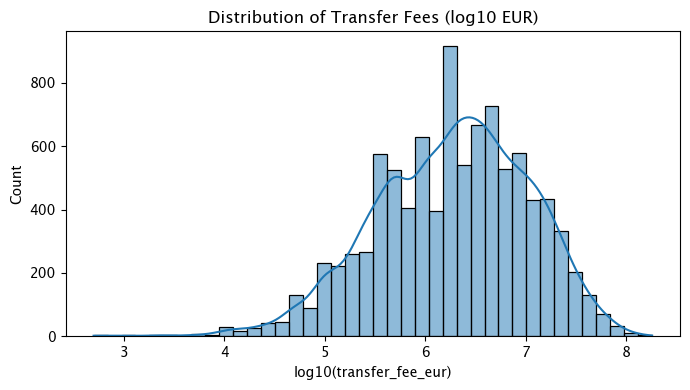

In [94]:
# Visualization 1: Distribution of transfer fees (log10 scale)
df_fee = df[df['transfer_fee_eur'].notna() & (df['transfer_fee_eur'] > 0)].copy()
df_fee['log_fee'] = np.log10(df_fee['transfer_fee_eur'])

plt.figure(figsize=(7, 4))
sns.histplot(df_fee['log_fee'], bins=40, kde=True)
plt.title('Distribution of Transfer Fees (log10 EUR)')
plt.xlabel('log10(transfer_fee_eur)')
plt.tight_layout()
plt.savefig(SCREENSHOTS_DIR / 'tm_02_fee_hist.png', dpi=200, bbox_inches='tight')
plt.show()

**Insight (Visualization 1):** Transfer fees are very right-skewed: many transfers have low or zero reported fees, while a small number are extremely expensive. Using a log transform makes the bulk of the data easier to see instead of letting a few huge deals dominate the plot. Because of this skew, the median and IQR usually describe a “typical” fee better than the mean.

### 2.2 Scatter Plot (Relationship)
This scatter plot shows the relationship between market value and transfer fee using log10-transformed axes.

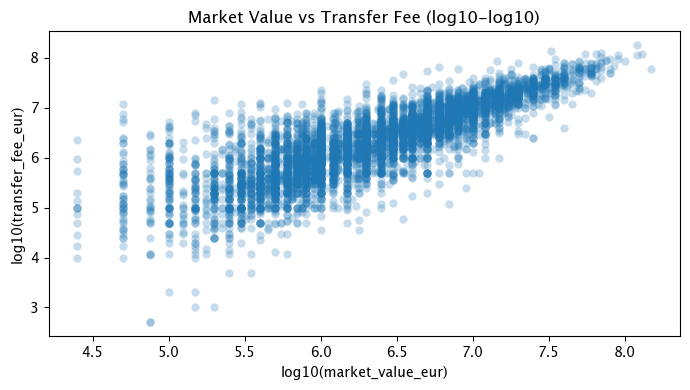

In [95]:
# Visualization 2: Relationship between market value and transfer fee (log-log via log10 transform)
df_mv = df[df['transfer_fee_eur'].notna() & df['market_value_eur'].notna() & (df['transfer_fee_eur'] > 0) & (df['market_value_eur'] > 0)].copy()
df_mv['log_mv'] = np.log10(df_mv['market_value_eur'])
df_mv['log_fee'] = np.log10(df_mv['transfer_fee_eur'])

plt.figure(figsize=(7, 4))
sns.scatterplot(
    data=df_mv.sample(n=min(6000, len(df_mv)), random_state=42),
    x='log_mv',
    y='log_fee',
    alpha=0.25,
    edgecolor=None,
    linewidth=0,
 )
plt.title('Market Value vs Transfer Fee (log10-log10)')
plt.xlabel('log10(market_value_eur)')
plt.ylabel('log10(transfer_fee_eur)')
plt.tight_layout()
plt.savefig(SCREENSHOTS_DIR / 'tm_03_value_vs_fee.png', dpi=200, bbox_inches='tight')
plt.show()

**Insight (Visualization 2):** Market value and transfer fee generally move in the same direction: players with higher market values often transfer for higher fees. The points are still widely spread, which shows market value alone does not determine the fee. Fees can also depend on contract length, timing, competition between clubs, and whether the fee is undisclosed, so this plot should be read as a relationship—not a cause-and-effect claim.

## Step 3: Data Preprocessing
This section demonstrates missing-value handling, duplicate removal, outlier detection (IQR), data reduction, scaling, and discretization.

### 3.1 Handling Missing Values
I first *detect and display* missing values, then apply simple, transparent imputations.
For fees, I preserve missingness with a boolean indicator so “unknown” is not confused with “zero.”

In [96]:
# 3.1 Missing Values: BEFORE
df_missing_before = df.copy()

missing_before_preview = df_missing_before[
    ['transfer_fee', 'transfer_fee_eur', 'market_value_in_eur', 'market_value_eur']
].head(12)
save_df_png(missing_before_preview, 'tm_04_missing_before.png')
missing_before_preview

,transfer_fee,transfer_fee_eur,market_value_in_eur,market_value_eur
0,0.0,0.0,NaN,NaN
1,NaN,NaN,NaN,NaN
2,0.0,0.0,400000.0,400000.0
3,0.0,0.0,NaN,NaN
4,0.0,0.0,600000.0,NaN
5,NaN,NaN,NaN,NaN
6,0.0,0.0,NaN,NaN
7,NaN,NaN,300000.0,300000.0
8,0.0,0.0,300000.0,300000.0
9,0.0,0.0,250000.0,250000.0


In [97]:
# Handle missing values
# - transfer_fee_eur: keep a missing-flag and fill missing with 0 for modeling/plotting convenience
# - market_value_eur: median imputation (robust to skew)
df_missing_after = df.copy()
df_missing_after['fee_is_missing'] = df_missing_after['transfer_fee_eur'].isna()
df_missing_after['transfer_fee_eur'] = df_missing_after['transfer_fee_eur'].fillna(0)

mv_median = df_missing_after['market_value_eur'].median(skipna=True)
df_missing_after['market_value_eur'] = df_missing_after['market_value_eur'].fillna(mv_median)

missing_after_preview = df_missing_after[['transfer_fee_eur', 'fee_is_missing', 'market_value_eur']].head(12)
save_df_png(missing_after_preview, 'tm_05_missing_after.png')
missing_after_preview

,transfer_fee_eur,fee_is_missing,market_value_eur
0,0.0,False,600000.0
1,0.0,True,600000.0
2,0.0,False,400000.0
3,0.0,False,600000.0
4,0.0,False,600000.0
5,0.0,True,600000.0
6,0.0,False,600000.0
7,0.0,True,300000.0
8,0.0,False,300000.0
9,0.0,False,250000.0


**Interpretation (Missing Values):** In transfer datasets, missing or undisclosed fees are common and should be treated as informative rather than “bad data.” For preprocessing, I preserve that information with a dedicated flag (`fee_is_missing`) and only fill missing fees with 0 so that downstream numeric operations run without dropping rows (the flag allows analysts to separate “unknown” from “known zero” cases later). For `market_value_eur`, I use median imputation because the variable is skewed and the median is less sensitive to extreme values than the mean.

### 3.2 Duplicate Detection and Removal
Duplicates can bias counts and summary statistics, so I detect and remove them before outlier handling and scaling.

In [98]:
# 3.2 Duplicates: detect and remove
dup_count = df_missing_after.duplicated().sum()
df_dedup = df_missing_after.drop_duplicates().copy()

dup_summary = pd.DataFrame({
    'duplicate_rows_detected': [int(dup_count)],
    'rows_before': [df_missing_after.shape[0]],
    'rows_after': [df_dedup.shape[0]],
})
save_df_png(dup_summary, 'tm_06_duplicates.png')
dup_summary

,duplicate_rows_detected,rows_before,rows_after
0,200,79846,79646


**Interpretation (Duplicates):** Duplicate records can arise in real-world ETL pipelines (periodic re-scrapes, merge logic issues, or repeated ingestion across updates). The working dataset intentionally includes duplicates so the lab can demonstrate detection and removal. Removing duplicates prevents double-counting, which would otherwise bias frequency counts, summary statistics, and correlations.

### 3.3 Outlier Detection and Removal (IQR)

I use the IQR rule on `log_fee` (log10 of positive fees). This keeps the outlier logic stable for very right-skewed values.

In [99]:
# 3.3 Outliers: IQR on log10(transfer_fee_eur) for positive fees
df_pos_fee = df_dedup[df_dedup['transfer_fee_eur'] > 0].copy()
df_pos_fee['log_fee'] = np.log10(df_pos_fee['transfer_fee_eur'])

q1 = df_pos_fee['log_fee'].quantile(0.25)
q3 = df_pos_fee['log_fee'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

iqr_bounds = pd.DataFrame({
    'q1': [q1],
    'q3': [q3],
    'iqr': [iqr],
    'lower': [lower],
    'upper': [upper],
})
save_df_png(iqr_bounds.round(4), 'tm_07_iqr_bounds.png')
iqr_bounds

,q1,q3,iqr,lower,upper
0,5.69897,6.829304,1.130334,4.003469,8.524804


In [100]:
# Outliers identified
outliers = df_pos_fee[(df_pos_fee['log_fee'] < lower) | (df_pos_fee['log_fee'] > upper)]

outliers_preview = outliers[
    ['player_name', 'from_club_name', 'to_club_name', 'transfer_fee_eur', 'market_value_eur']
].head(12)
save_df_png(outliers_preview, 'tm_08_outliers.png', max_cols=8)
outliers_preview

,player_name,from_club_name,to_club_name,transfer_fee_eur,market_value_eur
1097,Craig Dawson,Radcliffe,Rochdale,10000.0,600000.0
1356,Valentino Lazaro,GAK Youth,AKA Salzb. U15,6000.0,600000.0
5941,Caleb Okoli,Vicenza Yth.,Atalanta Youth,3000.0,600000.0
7512,Kristian Thorstvedt,Stabæk II,Viking,10000.0,600000.0
11281,Karol Angielski,Korona Kielce,Slask Wroclaw,2000.0,100000.0
14961,Aleksandr Sobolev,Din. Barnaul II,Tom Tomsk II,3000.0,600000.0
16165,Ersin Destanoğlu,Bayrampasa Yth,Besiktas Yth,6000.0,600000.0
19516,Lucas Taylor,Estoril Praia,SC Dnipro-1,5000.0,350000.0
21587,Fernand Goure,AS Denguélé,M. Netanya U19,8000.0,600000.0
24297,Nikolay Zolotov,Soligorsk,Vitebsk,2000.0,150000.0


In [101]:
# Remove outliers (keep only in-range)
df_no_outliers = df_pos_fee[(df_pos_fee['log_fee'] >= lower) & (df_pos_fee['log_fee'] <= upper)].copy()

outliers_removed_summary = pd.DataFrame({
    'rows_before': [df_pos_fee.shape[0]],
    'rows_after': [df_no_outliers.shape[0]],
    'removed_rows': [df_pos_fee.shape[0] - df_no_outliers.shape[0]],
})

# Screenshot-style evidence: small before/after preview (rubric-friendly)
preview_cols = ['transfer_fee_eur', 'market_value_eur', 'log_fee', 'transfer_year']
before_preview = df_pos_fee[preview_cols].head(5).reset_index(drop=True)
after_preview = df_no_outliers[preview_cols].head(5).reset_index(drop=True)
outliers_removed_preview = pd.concat(
    [before_preview.add_prefix('before_'), after_preview.add_prefix('after_')], axis=1
)
save_df_png(outliers_removed_preview, 'tm_09_outliers_removed.png')

outliers_removed_summary, outliers_removed_preview

(   rows_before  rows_after  removed_rows
 0         9509        9467            42,
    before_transfer_fee_eur  before_market_value_eur  before_log_fee  \
 0                 400000.0                 450000.0        5.602060   
 1                6750000.0               12000000.0        6.829304   
 2                  80000.0                 400000.0        4.903090   
 3                1000000.0                1300000.0        6.000000   
 4                 300000.0                 400000.0        5.477121   
 
    before_transfer_year  after_transfer_fee_eur  after_market_value_eur  \
 0                  2024                400000.0                450000.0   
 1                  2011               6750000.0              12000000.0   
 2                  2020                 80000.0                400000.0   
 3                  2011               1000000.0               1300000.0   
 4                  2024                300000.0                400000.0   
 
    after_log_fee  afte

**Interpretation (Outliers / IQR):** Because fees are very right-skewed, I detect outliers using the IQR rule on `log_fee` (log10 of positive fees). This reduces the impact of extreme deals when summarizing the dataset. It also means some legitimate high-fee transfers may be excluded, so I interpret the results with that in mind.

### 3.4 Data Reduction
To keep computations fast and the notebook readable, I sample rows and drop high-cardinality text fields that are not needed for numeric statistical analysis.

In [102]:
# 3.4 Data Reduction: sample + drop high-cardinality text columns
df_before_reduction = df_no_outliers.copy()
df_sampled = df_before_reduction.sample(frac=0.35, random_state=42)
df_reduced = df_sampled.drop(columns=['player_name', 'from_club_name', 'to_club_name', 'transfer_date'], errors='ignore')

# Screenshot-style evidence: before/after preview + shape
reduction_cols = ['transfer_fee_eur', 'market_value_eur', 'transfer_year', 'fee_is_missing']
before_head = df_before_reduction[reduction_cols].head(5).reset_index(drop=True)
after_head = df_reduced[reduction_cols].head(5).reset_index(drop=True)
reduction_preview = pd.concat(
    [before_head.add_prefix('before_'), after_head.add_prefix('after_')], axis=1
)
save_df_png(reduction_preview, 'tm_10_reduction.png')

reduction_summary = pd.DataFrame({
    'stage': ['before_reduction', 'after_reduction'],
    'rows': [df_before_reduction.shape[0], df_reduced.shape[0]],
    'cols': [df_before_reduction.shape[1], df_reduced.shape[1]],
})

reduction_summary, reduction_preview

(              stage  rows  cols
 0  before_reduction  9467    18
 1   after_reduction  3313    14,
    before_transfer_fee_eur  before_market_value_eur  before_transfer_year  \
 0                 400000.0                 450000.0                  2024   
 1                6750000.0               12000000.0                  2011   
 2                  80000.0                 400000.0                  2020   
 3                1000000.0                1300000.0                  2011   
 4                 300000.0                 400000.0                  2024   
 
    before_fee_is_missing  after_transfer_fee_eur  after_market_value_eur  \
 0                  False                900000.0                700000.0   
 1                  False              16000000.0               1500000.0   
 2                  False               2000000.0               1000000.0   
 3                  False                300000.0                 50000.0   
 4                  False               20000

### 3.5 Scaling and Discretization
I apply Min–Max scaling so numeric variables share a comparable 0–1 scale, then discretize fees into interpretable buckets (e.g., `<=1m`, `1–5m`, `5–20m`).

**Interpretation (Reduction):** I reduce the dataset by sampling and dropping high-cardinality text columns (e.g., names) to keep the analysis focused and computationally efficient while preserving the numeric signals needed for statistics. This reduction step helps ensure the rest of the preprocessing/statistics is fast to run and easy to interpret in a lab setting.

In [103]:
# 3.5 Scaling and Discretization
features_to_scale = ['transfer_fee_eur', 'market_value_eur']

scaling_before = df_reduced[features_to_scale].head(8)
save_df_png(scaling_before, 'tm_11_scaling_before.png')
scaling_before

,transfer_fee_eur,market_value_eur
6462,900000.0,700000.0
38794,16000000.0,1500000.0
52076,2000000.0,1000000.0
45465,300000.0,50000.0
20077,2000000.0,1000000.0
26494,50000.0,400000.0
8764,27000000.0,25000000.0
42543,4150000.0,4000000.0


In [104]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_reduced[features_to_scale])
df_scaled = df_reduced.copy()
df_scaled[features_to_scale] = scaled

# Screenshot required: AFTER scaling
scaling_after = df_scaled[features_to_scale].head(8)
save_df_png(scaling_after, 'tm_12_scaling_after.png')

# Discretization example: bin fee into categories (based on scaled fee is less interpretable, so use original fee)
# Use the non-scaled fee from df_reduced for bins, then keep the label on df_scaled
fee_bins = [0, 1_000_000, 5_000_000, 20_000_000, 100_000_000, np.inf]
fee_labels = ['<=1m', '1-5m', '5-20m', '20-100m', '>100m']
df_scaled['fee_bucket'] = pd.cut(df_reduced['transfer_fee_eur'], bins=fee_bins, labels=fee_labels, include_lowest=True)

discretization_preview = df_scaled[['transfer_fee_eur', 'fee_bucket']].head(12)
save_df_png(discretization_preview, 'tm_13_discretization.png')

# Use this cleaned dataset for the statistics section
df_final = df_scaled.copy()

scaling_after, discretization_preview

(       transfer_fee_eur  market_value_eur
 6462           0.006586          0.005626
 38794          0.118447          0.012294
 52076          0.014735          0.008127
 45465          0.002141          0.000208
 20077          0.014735          0.008127
 26494          0.000289          0.003126
 8764           0.199935          0.208168
 42543          0.030662          0.033132,
        transfer_fee_eur fee_bucket
 6462           0.006586       <=1m
 38794          0.118447      5-20m
 52076          0.014735       1-5m
 45465          0.002141       <=1m
 20077          0.014735       1-5m
 26494          0.000289       <=1m
 8764           0.199935    20-100m
 42543          0.030662       1-5m
 59714          0.000326       <=1m
 50198          0.371801    20-100m
 28464          0.009179       1-5m
 69282          0.009179       1-5m)

## Step 4: Statistical Analysis
This section computes general overview, central tendency, dispersion, and correlation.

#### 4.1 General overview
I use `.info()` to confirm data types/non-null counts, and `.describe()` to summarize distributions (count/mean/std/min/max/quartiles).

### Statistical analysis goals
This section summarizes the cleaned dataset with descriptive statistics, then quantifies relationships using correlation (note: correlation does not imply causation).

In [105]:
# 4.1 General Overview (.info and .describe)
buf = io.StringIO()
df_final.info(buf=buf)
info_text = buf.getvalue()
save_text_png(info_text, 'tm_14_info.png')
print(info_text)

<class 'pandas.DataFrame'>
Index: 3313 entries, 6462 to 41761
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   player_id            3313 non-null   int64   
 1   transfer_season      3313 non-null   str     
 2   from_club_id         3313 non-null   int64   
 3   to_club_id           3313 non-null   int64   
 4   transfer_fee         3313 non-null   float64 
 5   market_value_in_eur  3118 non-null   float64 
 6   transfer_fee_eur     3313 non-null   float64 
 7   market_value_eur     3313 non-null   float64 
 8   transfer_year        3313 non-null   int64   
 9   fee_missing          3313 non-null   bool    
 10  value_missing        3313 non-null   bool    
 11  fee_bucket           3313 non-null   category
 12  fee_is_missing       3313 non-null   bool    
 13  log_fee              3313 non-null   float64 
dtypes: bool(3), category(1), float64(5), int64(4), str(1)
memory usage: 297.9 KB



In [106]:
desc = df_final.describe(include='all')
save_df_png(desc.fillna(''), 'tm_15_describe.png', max_rows=20, max_cols=12, font_size=7)
desc

,player_id,transfer_season,from_club_id,to_club_id,transfer_fee,market_value_in_eur,transfer_fee_eur,market_value_eur,transfer_year,fee_missing,value_missing,fee_bucket,fee_is_missing,log_fee
count,3.313000e+03,3313,3313.000000,3313.000000,3.313000e+03,3.118000e+03,3313.000000,3313.000000,3313.000000,3313,3313,3313,3313,3313.000000
unique,NaN,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,5,1,NaN
top,NaN,23/24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,<=1m,False,NaN
freq,NaN,439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3313,3088,1185,3313,NaN
mean,3.579204e+05,NaN,5732.983097,4166.281014,6.251684e+06,5.821697e+06,0.046661,0.045223,2019.556897,NaN,NaN,NaN,NaN,6.283892
std,2.329906e+05,NaN,12778.609967,11067.118499,1.135634e+07,1.029901e+07,0.084837,0.082999,3.921771,NaN,NaN,NaN,NaN,0.742744
min,3.333000e+03,NaN,2.000000,2.000000,1.100000e+04,2.500000e+04,0.000000,0.000000,2004.000000,NaN,NaN,NaN,NaN,4.041393
25%,1.783130e+05,NaN,332.000000,255.000000,5.500000e+05,7.500000e+05,0.004141,0.004793,2017.000000,NaN,NaN,NaN,NaN,5.755875
50%,3.239540e+05,NaN,1003.000000,714.000000,2.000000e+06,2.000000e+06,0.014735,0.014795,2020.000000,NaN,NaN,NaN,NaN,6.301030
75%,4.968570e+05,NaN,3722.000000,2424.000000,6.800000e+06,6.000000e+06,0.051775,0.045635,2023.000000,NaN,NaN,NaN,NaN,6.845098


#### 4.2 Central tendency
Minimum/maximum show extremes; mean/median show typical values; mode shows the most frequent value (useful when repeated values exist).

In [107]:
# 4.2 Central Tendency Measures
numeric = df_final.select_dtypes(include=[np.number])
central = pd.DataFrame({
    'min': numeric.min(),
    'max': numeric.max(),
    'mean': numeric.mean(),
    'median': numeric.median(),
    'mode': numeric.mode().iloc[0],
})
save_df_png(central.round(6), 'tm_16_central_tendency.png', max_rows=25, max_cols=12, font_size=7)
central

,min,max,mean,median,mode
player_id,3333.000000,1.285176e+06,3.579204e+05,3.239540e+05,1.497520e+05
from_club_id,2.000000,1.104580e+05,5.732983e+03,1.003000e+03,1.200000e+01
to_club_id,2.000000,1.149770e+05,4.166281e+03,7.140000e+02,6.310000e+02
transfer_fee,11000.000000,1.350000e+08,6.251684e+06,2.000000e+06,2.000000e+06
market_value_in_eur,25000.000000,1.200000e+08,5.821697e+06,2.000000e+06,1.500000e+06
transfer_fee_eur,0.000000,1.000000e+00,4.666131e-02,1.473453e-02,1.473453e-02
market_value_eur,0.000000,1.000000e+00,4.522329e-02,1.479475e-02,4.792665e-03
transfer_year,2004.000000,2.025000e+03,2.019557e+03,2.020000e+03,2.024000e+03
log_fee,4.041393,8.130334e+00,6.283892e+00,6.301030e+00,6.301030e+00


#### 4.3 Dispersion
Range/IQR/variance/std quantify spread. With skewed data, IQR often describes the spread more clearly than variance/std.

In [108]:
# 4.3 Dispersion Measures
dispersion = pd.DataFrame({
    'range': numeric.max() - numeric.min(),
    'q1': numeric.quantile(0.25),
    'q3': numeric.quantile(0.75),
    'iqr': numeric.quantile(0.75) - numeric.quantile(0.25),
    'variance': numeric.var(),
    'std_dev': numeric.std(),
})
save_df_png(dispersion.round(6), 'tm_17_dispersion.png', max_rows=25, max_cols=12, font_size=7)
dispersion

,range,q1,q3,iqr,variance,std_dev
player_id,1.281843e+06,178313.000000,4.968570e+05,3.185440e+05,5.428460e+10,2.329906e+05
from_club_id,1.104560e+05,332.000000,3.722000e+03,3.390000e+03,1.632929e+08,1.277861e+04
to_club_id,1.149750e+05,255.000000,2.424000e+03,2.169000e+03,1.224811e+08,1.106712e+04
transfer_fee,1.349890e+08,550000.000000,6.800000e+06,6.250000e+06,1.289665e+14,1.135634e+07
market_value_in_eur,1.199750e+08,750000.000000,6.000000e+06,5.250000e+06,1.060696e+14,1.029901e+07
transfer_fee_eur,1.000000e+00,0.004141,5.177459e-02,4.763351e-02,7.197246e-03,8.483659e-02
market_value_eur,1.000000e+00,0.004793,4.563451e-02,4.084184e-02,6.888896e-03,8.299937e-02
transfer_year,2.100000e+01,2017.000000,2.023000e+03,6.000000e+00,1.538029e+01,3.921771e+00
log_fee,4.088941e+00,5.755875,6.845098e+00,1.089223e+00,5.516683e-01,7.427438e-01


#### 4.4 Correlation analysis
I compute the correlation matrix for numeric columns to see which variables move together (linear association). I also include an optional heatmap for readability.

In [109]:
# 4.4 Correlation Analysis
corr = numeric.corr(numeric_only=True)
save_df_png(corr.round(3), 'tm_18_correlation.png', max_rows=25, max_cols=25, font_size=7)
corr

,player_id,from_club_id,to_club_id,transfer_fee,market_value_in_eur,transfer_fee_eur,market_value_eur,transfer_year,log_fee
player_id,1.000000,0.209362,0.169795,-0.047297,-0.074311,-0.047542,-0.079618,0.622591,-0.099997
from_club_id,0.209362,1.000000,0.291921,-0.162335,-0.143417,-0.159452,-0.158858,0.015029,-0.346299
to_club_id,0.169795,0.291921,1.000000,-0.114500,-0.091335,-0.113875,-0.108285,0.052375,-0.261061
transfer_fee,-0.047297,-0.162335,-0.114500,1.000000,0.890064,0.991341,0.869810,0.055436,0.676846
market_value_in_eur,-0.074311,-0.143417,-0.091335,0.890064,1.000000,0.883663,0.985910,0.078566,0.624294
transfer_fee_eur,-0.047542,-0.159452,-0.113875,0.991341,0.883663,1.000000,0.861399,0.057611,0.679778
market_value_eur,-0.079618,-0.158858,-0.108285,0.869810,0.985910,0.861399,1.000000,0.099034,0.611651
transfer_year,0.622591,0.015029,0.052375,0.055436,0.078566,0.057611,0.099034,1.000000,0.071472
log_fee,-0.099997,-0.346299,-0.261061,0.676846,0.624294,0.679778,0.611651,0.071472,1.000000


**Interpretation (Statistics & Correlation):** The descriptive statistics match what the charts showed: fee-related variables are highly skewed, so the mean is usually higher than the median, and the spread is large. The correlation matrix shows which numeric columns tend to move together (for example, higher market value often comes with higher fees). Correlation does not prove that one variable causes another—other factors (league, age, contract length, and reporting practices) can affect both at the same time.

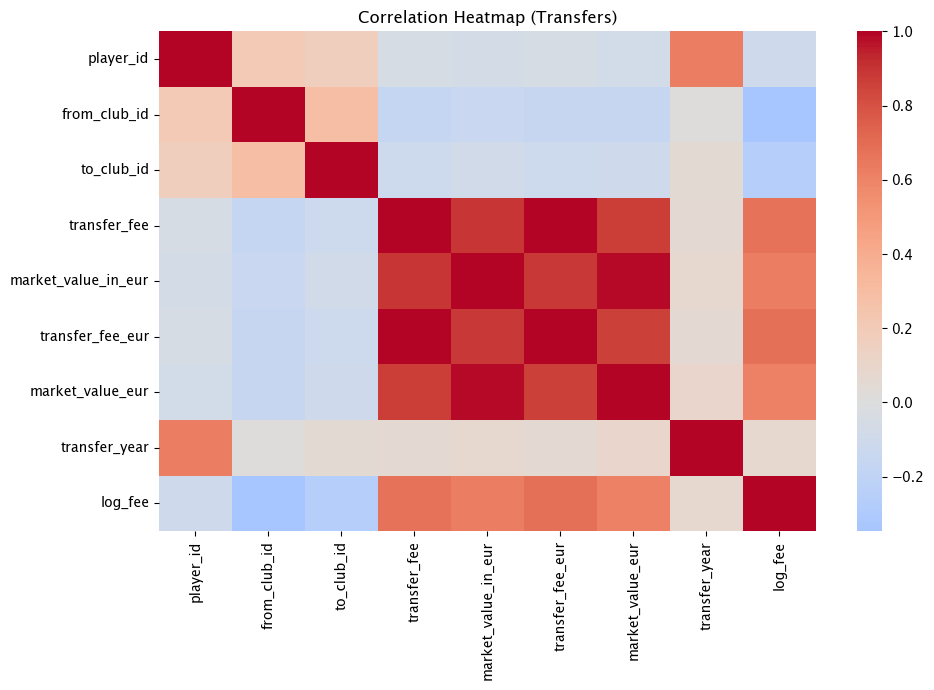

In [110]:
# Optional: correlation heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Transfers)')
plt.tight_layout()
plt.savefig(SCREENSHOTS_DIR / 'tm_19_heatmap.png', dpi=200, bbox_inches='tight')
plt.show()

## Screenshot Checklist (Transfermarkt Transfers)
- `df.head()` output (tm_01_head.png)
- Two (or more) visualizations + written insights (tm_02_fee_hist.png, tm_03_value_vs_fee.png)
- Missing values: before + after (tm_04_missing_before.png, tm_05_missing_after.png)
- Duplicates: before vs after shape (tm_06_duplicates.png)
- IQR bounds + outliers + after outlier handling (tm_07_iqr_bounds.png, tm_08_outliers.png, tm_09_outliers_removed.png)
- Data reduction: before/after preview + shape (tm_10_reduction.png)
- Scaling/discretization: before + after (tm_11_scaling_before.png, tm_12_scaling_after.png, tm_13_discretization.png)
- `.info()` and `.describe()` (tm_14_info.png, tm_15_describe.png)
- Central tendency + dispersion (tm_16_central_tendency.png, tm_17_dispersion.png)
- Correlation matrix (tm_18_correlation.png)
- Correlation heatmap (tm_19_heatmap.png, optional)

## Conclusion
- Transfer fees are strongly right-skewed: many transfers have low/zero reported fees, while a small number of deals are extremely large. Using a log transform made the distribution easier to visualize and summarize.
- Market value and transfer fee generally move in the same direction, but there is still a lot of spread. This suggests market value is helpful context, but not the only factor behind a fee.
- The preprocessing steps mattered: handling missing values with an indicator, removing duplicates, and managing extreme values made the summary statistics and correlations more stable and easier to interpret.

**Limitations:**
- Some transfer fees are missing because they are undisclosed; filling missing fees with 0 is done for convenience, and the `fee_is_missing` flag should be used when interpreting results.
- Outlier handling can remove legitimate high-profile transfers; the results here are intended for exploratory analysis and should be compared with a “no outlier removal” version if used for conclusions.

**Possible next steps:**
- Add more explanatory variables (league, player age/position, contract length) and fit a simple regression model to quantify which factors relate most to transfer fees.
- Repeat the same analysis by season to check whether patterns are consistent over time.